<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/Autoencoder_mode_mixing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 导入数据集
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 26421880 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 29515 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 4422102 bytes.
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 5148 bytes.
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


搭建神经网络

In [2]:


#lrelu函数
def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

#输入到网络的数据
#图片28*28,color_channel是1
inputs_ = tf.placeholder(tf.float32, [None, 28, 28, 1])
#原始数据
targets_ = tf.placeholder(tf.float32, [None, 28, 28, 1])


### Encoder
'''
filters: 32个卷积核
kernel_size: 卷积核大小
strides: 长宽步长都是1
padding: 边缘填充
use_bias: 在卷积中添加偏置
activation: 激活函数
'''
with tf.name_scope('en-convolutions'):
    conv1 = tf.layers.conv2d(inputs_, filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu, )
# 卷积时padding是SAME,所以仍然是28*28
# now 28x28x32
'''
将第一卷积层的结果输入进来
pool_size: 池化窗口
strides: 步长
'''
with tf.name_scope('en-pooling'):
    maxpool1 = tf.layers.max_pooling2d(conv1,
                                       pool_size=(2, 2),
                                       strides=(2, 2), )

# 池化之后变成了14*14
# now 14x14x32
'''
第二卷积层
参数和第一卷积层相似
'''
with tf.name_scope('en-convolutions'):
    conv2 = tf.layers.conv2d(maxpool1,
                             filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu, )

'''
第二池化层
和上面的池化层参数基本一样
'''
#  now 14x14x32
with tf.name_scope('encoding'):
    encoded = tf.layers.max_pooling2d(conv2,
                                      pool_size=(2, 2),
                                      strides=(2, 2), )
#经过pooling层之后,大小是7x7x32,Encoding完成
# now 7x7x32

#编码之后进行解码
### Decoder
with tf.name_scope('decoder'):
    conv3 = tf.layers.conv2d(encoded,
                             filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu)
    #  现在是7x7x32
    #开始反卷积
    upsamples1 = tf.layers.conv2d_transpose(conv3,
                                            filters=32,
                                            kernel_size=3,
                                            padding='SAME',
                                            strides=2,
                                            name='upsample1')
    # now 14x14x32
    #反卷积
    upsamples2 = tf.layers.conv2d_transpose(upsamples1,
                                            filters=32,
                                            kernel_size=3,
                                            padding='SAME',
                                            strides=2,
                                            name='upsamples2')
    # now 28x28x32
    #卷积,filter映射成1
    logits = tf.layers.conv2d(upsamples2,
                              filters=1,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              name='logits',
                              padding='SAME',
                              use_bias=True)
    # 此时的数据是 28x28x1
    # 通过sigmoid传递logits以获得重建图像
    decoded = tf.sigmoid(logits, name='recon')

# 定义损失函数和优化器
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits, labels=targets_)

learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# 训练
sess = tf.Session()

saver = tf.train.Saver()
loss = []
valid_loss = []

display_step = 1
epochs = 50
batch_size = 64
lr = 1e-5
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./graphs', sess.graph)

noise_factor = 1
Matrix=np.random.normal(loc=0.0, scale=1.0, size=( 28, 28, 1))


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Define transmission matrix

In [0]:
from sklearn.preprocessing import normalize

orgin_m = 28
orgin_n = 28
after_m = 28
after_n = 28

TM_shape = (after_m * after_n, orgin_m * orgin_n )
TM = np.random.random(TM_shape) + np.random.random(TM_shape)* 1j
norm = normalize(np.abs(TM), axis = 0 , norm='l2')  # normalize the transmission matrix 
TM = norm * TM / np.abs(TM)



Mode mixing function

In [0]:
from numpy.fft import fft2,ifft2,fftshift

def Mode_mixing_batch(imgs,batch_size):
  output_imgs = np.empty((batch_size,28,28,1),dtype=float)
  for i in range(batch_size):
    modes = fft2(imgs[i])
    modes_list = modes.flatten()
    output = TM@modes_list
    output = output.reshape((28,28,1)) 
    output_imgs[i] = np.abs(ifft2(output))
  return output_imgs


In [0]:
batch_size = 10
batch_train_x = mnist.train.next_batch(batch_size)
batch_test_x = mnist.test.next_batch(batch_size)
        
imgs_test = batch_test_x[0].reshape((-1, 28, 28, 1))
x_test_noisy =  Mode_mixing_batch(imgs_test,batch_size)


训练模型

Epoch: 1/50... Training loss: 0.4939 Validation loss: 0.4599


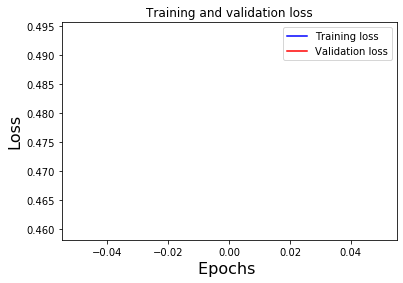

<Figure size 432x288 with 0 Axes>

Epoch: 2/50... Training loss: 0.4171 Validation loss: 0.4555


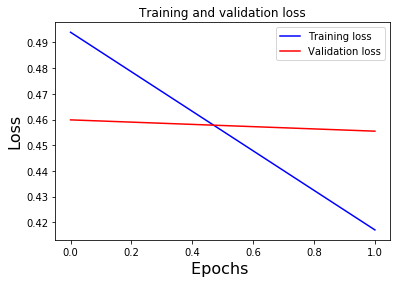

<Figure size 432x288 with 0 Axes>

Epoch: 3/50... Training loss: 0.3923 Validation loss: 0.3929


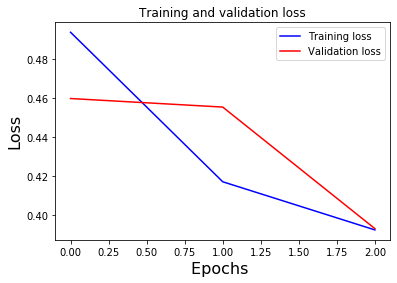

<Figure size 432x288 with 0 Axes>

Epoch: 4/50... Training loss: 0.4411 Validation loss: 0.4354


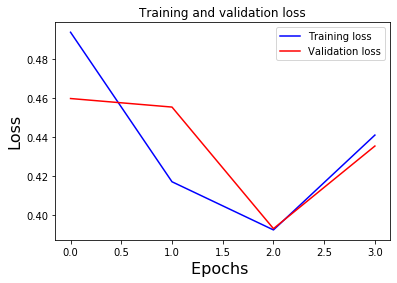

<Figure size 432x288 with 0 Axes>

Epoch: 5/50... Training loss: 0.4562 Validation loss: 0.3779


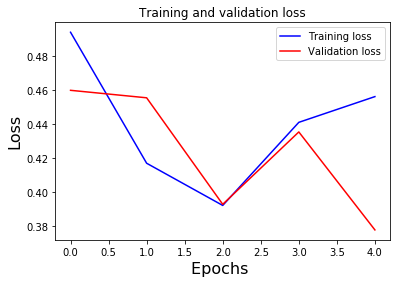

<Figure size 432x288 with 0 Axes>

Epoch: 6/50... Training loss: 0.4108 Validation loss: 0.4159


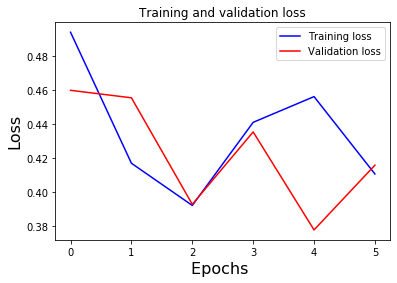

<Figure size 432x288 with 0 Axes>

Epoch: 7/50... Training loss: 0.4224 Validation loss: 0.3724


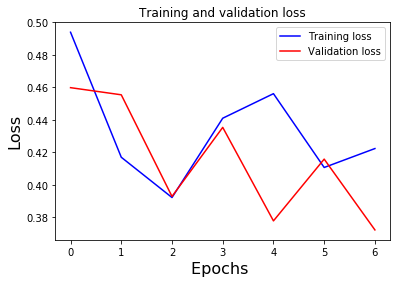

<Figure size 432x288 with 0 Axes>

Epoch: 8/50... Training loss: 0.4007 Validation loss: 0.3829


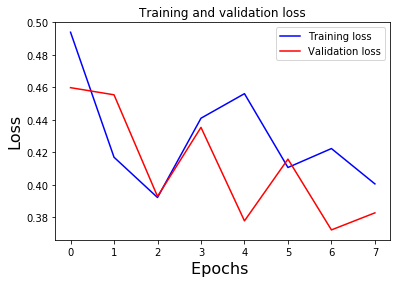

<Figure size 432x288 with 0 Axes>

Epoch: 9/50... Training loss: 0.3873 Validation loss: 0.3984


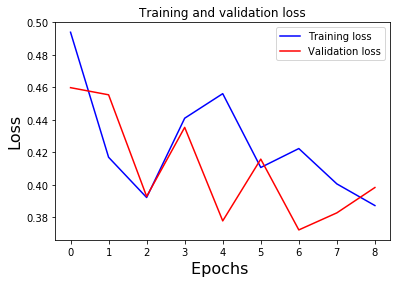

<Figure size 432x288 with 0 Axes>

Epoch: 10/50... Training loss: 0.4191 Validation loss: 0.4099


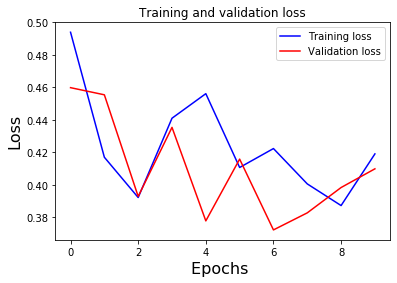

<Figure size 432x288 with 0 Axes>

Epoch: 11/50... Training loss: 0.4487 Validation loss: 0.3941


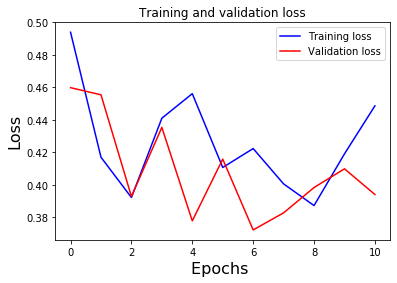

<Figure size 432x288 with 0 Axes>

Epoch: 12/50... Training loss: 0.3929 Validation loss: 0.4015


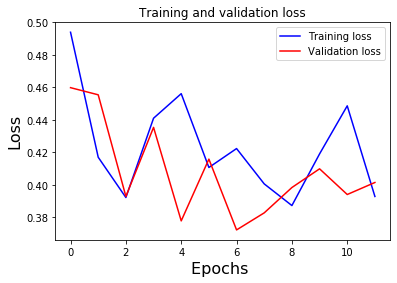

<Figure size 432x288 with 0 Axes>

Epoch: 13/50... Training loss: 0.3763 Validation loss: 0.4039


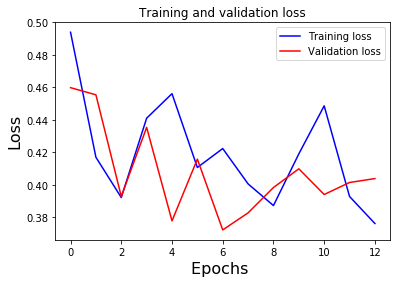

<Figure size 432x288 with 0 Axes>

Epoch: 14/50... Training loss: 0.3875 Validation loss: 0.3750


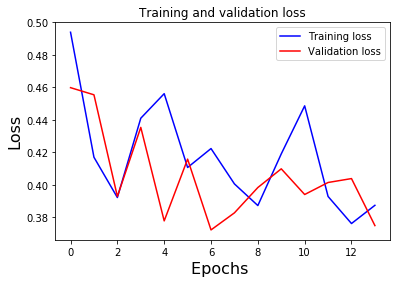

<Figure size 432x288 with 0 Axes>

Epoch: 15/50... Training loss: 0.3645 Validation loss: 0.3005


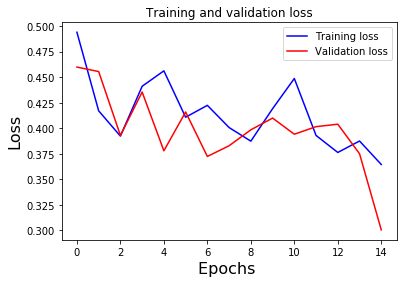

<Figure size 432x288 with 0 Axes>

Epoch: 16/50... Training loss: 0.3849 Validation loss: 0.3145


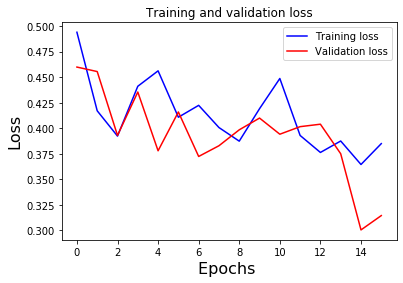

<Figure size 432x288 with 0 Axes>

Epoch: 17/50... Training loss: 0.3275 Validation loss: 0.3468


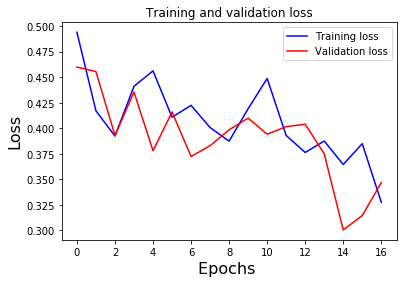

<Figure size 432x288 with 0 Axes>

Epoch: 18/50... Training loss: 0.3454 Validation loss: 0.3839


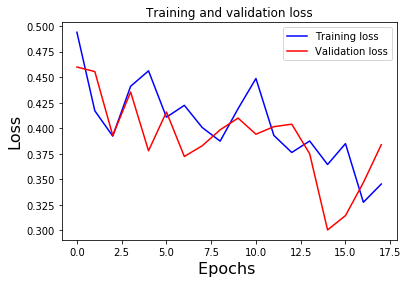

<Figure size 432x288 with 0 Axes>

Epoch: 19/50... Training loss: 0.3403 Validation loss: 0.3279


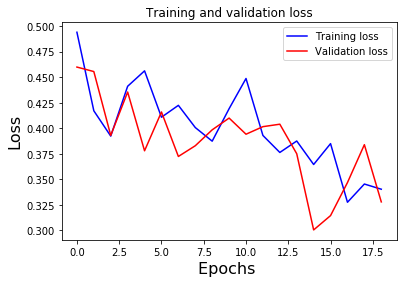

<Figure size 432x288 with 0 Axes>

Epoch: 20/50... Training loss: 0.3279 Validation loss: 0.4450


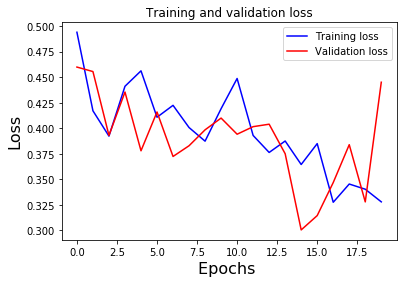

<Figure size 432x288 with 0 Axes>

Epoch: 21/50... Training loss: 0.3887 Validation loss: 0.3565


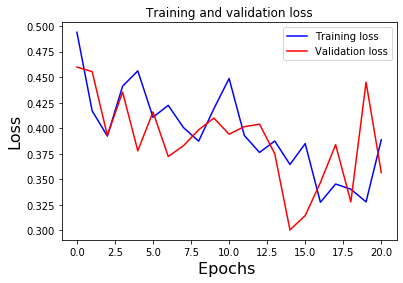

<Figure size 432x288 with 0 Axes>

Epoch: 22/50... Training loss: 0.3721 Validation loss: 0.3934


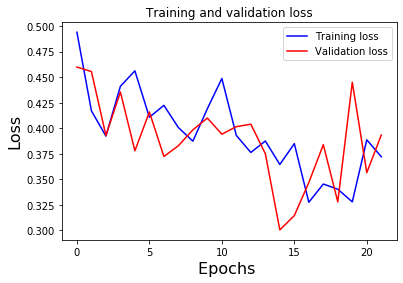

<Figure size 432x288 with 0 Axes>

Epoch: 23/50... Training loss: 0.3530 Validation loss: 0.3408


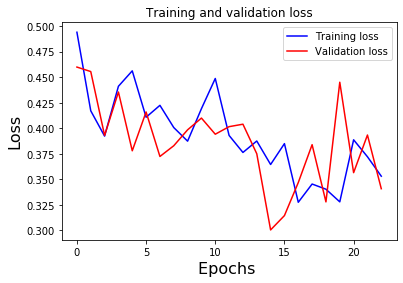

<Figure size 432x288 with 0 Axes>

Epoch: 24/50... Training loss: 0.4029 Validation loss: 0.3897


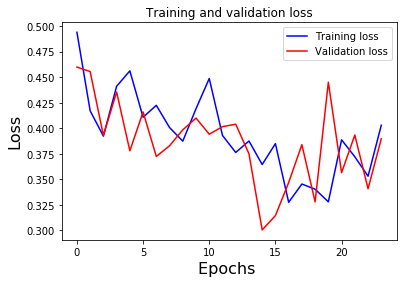

<Figure size 432x288 with 0 Axes>

Epoch: 25/50... Training loss: 0.3821 Validation loss: 0.3439


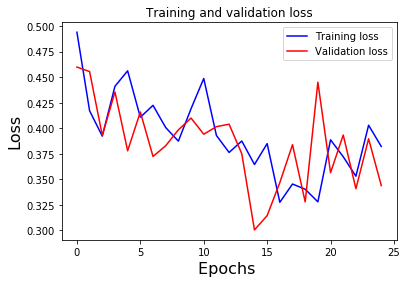

<Figure size 432x288 with 0 Axes>

Epoch: 26/50... Training loss: 0.3464 Validation loss: 0.3440


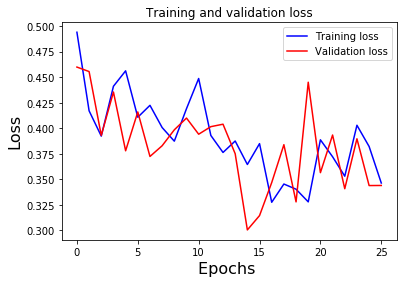

<Figure size 432x288 with 0 Axes>

Epoch: 27/50... Training loss: 0.3714 Validation loss: 0.3814


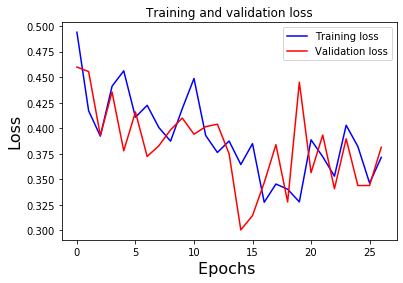

<Figure size 432x288 with 0 Axes>

Epoch: 28/50... Training loss: 0.3165 Validation loss: 0.2996


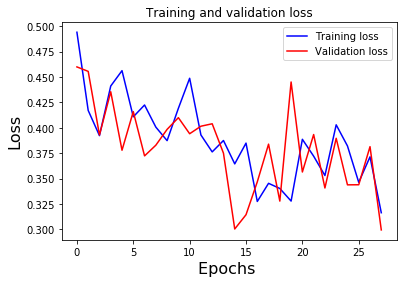

<Figure size 432x288 with 0 Axes>

Epoch: 29/50... Training loss: 0.3277 Validation loss: 0.3798


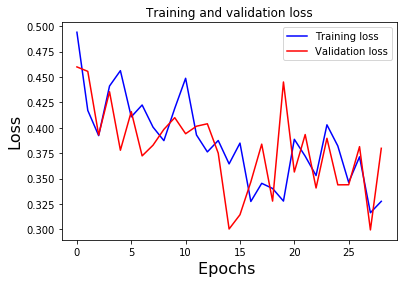

<Figure size 432x288 with 0 Axes>

Epoch: 30/50... Training loss: 0.3486 Validation loss: 0.3205


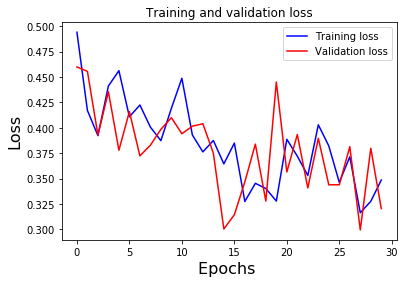

<Figure size 432x288 with 0 Axes>

Epoch: 31/50... Training loss: 0.3328 Validation loss: 0.3489


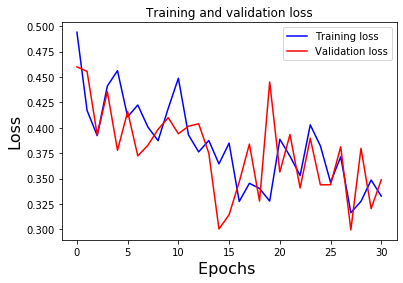

<Figure size 432x288 with 0 Axes>

Epoch: 32/50... Training loss: 0.3846 Validation loss: 0.3451


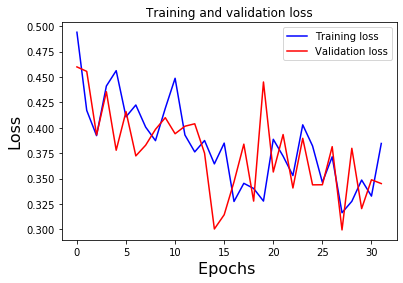

<Figure size 432x288 with 0 Axes>

Epoch: 33/50... Training loss: 0.2939 Validation loss: 0.3570


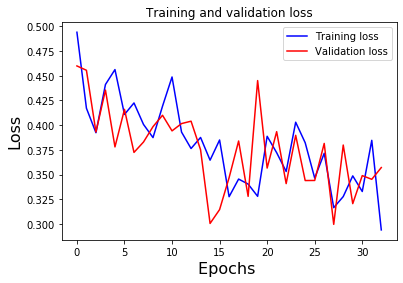

<Figure size 432x288 with 0 Axes>

Epoch: 34/50... Training loss: 0.3709 Validation loss: 0.3656


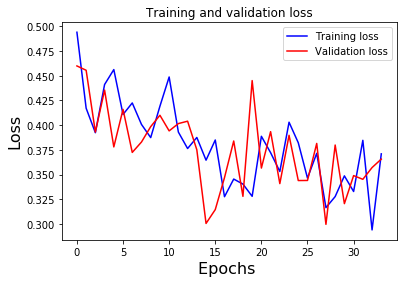

<Figure size 432x288 with 0 Axes>

Epoch: 35/50... Training loss: 0.3483 Validation loss: 0.3386


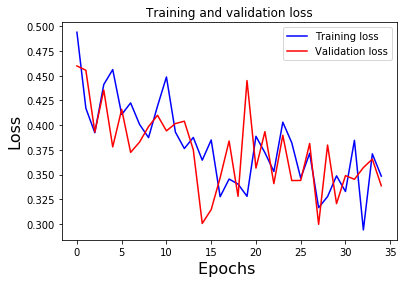

<Figure size 432x288 with 0 Axes>

Epoch: 36/50... Training loss: 0.3045 Validation loss: 0.3730


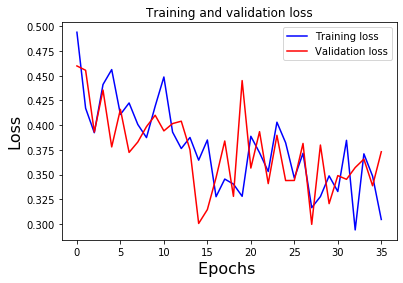

<Figure size 432x288 with 0 Axes>

Epoch: 37/50... Training loss: 0.3305 Validation loss: 0.3409


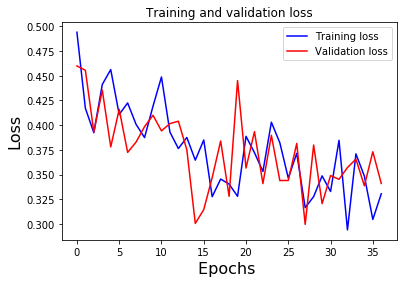

<Figure size 432x288 with 0 Axes>

Epoch: 38/50... Training loss: 0.3361 Validation loss: 0.3517


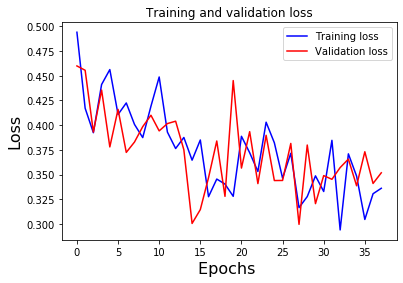

<Figure size 432x288 with 0 Axes>

Epoch: 39/50... Training loss: 0.3401 Validation loss: 0.3904


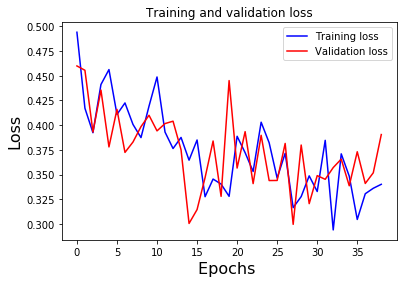

<Figure size 432x288 with 0 Axes>

Epoch: 40/50... Training loss: 0.2979 Validation loss: 0.3785


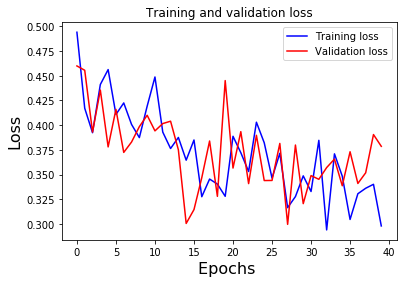

<Figure size 432x288 with 0 Axes>

Epoch: 41/50... Training loss: 0.3276 Validation loss: 0.3134


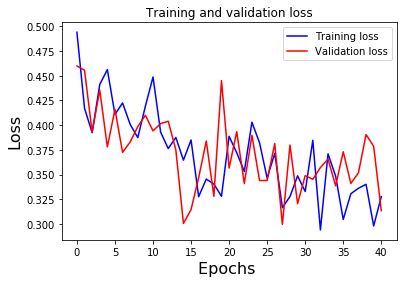

<Figure size 432x288 with 0 Axes>

Epoch: 42/50... Training loss: 0.3549 Validation loss: 0.3170


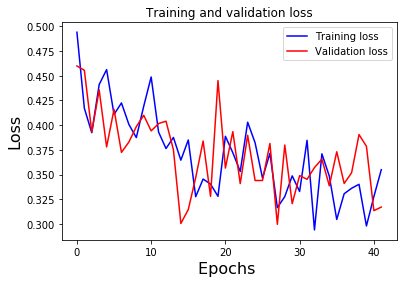

<Figure size 432x288 with 0 Axes>

Epoch: 43/50... Training loss: 0.3474 Validation loss: 0.3285


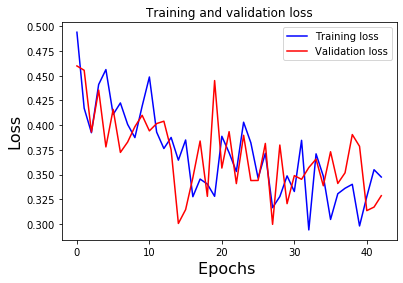

<Figure size 432x288 with 0 Axes>

Epoch: 44/50... Training loss: 0.3191 Validation loss: 0.3147


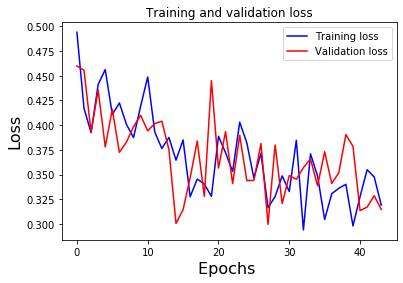

<Figure size 432x288 with 0 Axes>

Epoch: 45/50... Training loss: 0.3599 Validation loss: 0.3085


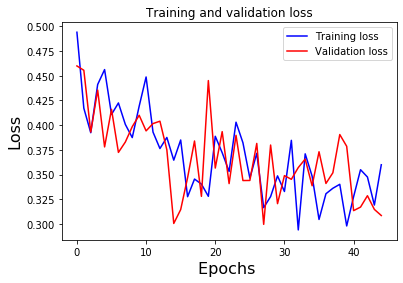

<Figure size 432x288 with 0 Axes>

Epoch: 46/50... Training loss: 0.3311 Validation loss: 0.4088


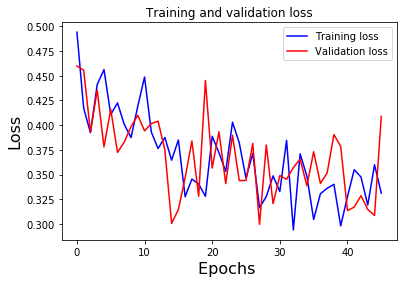

<Figure size 432x288 with 0 Axes>

Epoch: 47/50... Training loss: 0.3596 Validation loss: 0.2777


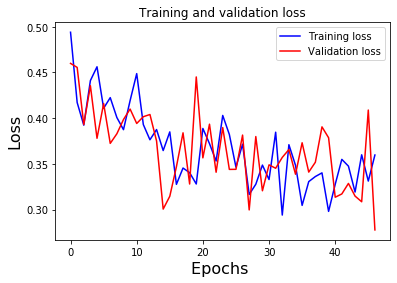

<Figure size 432x288 with 0 Axes>

Epoch: 48/50... Training loss: 0.3035 Validation loss: 0.3121


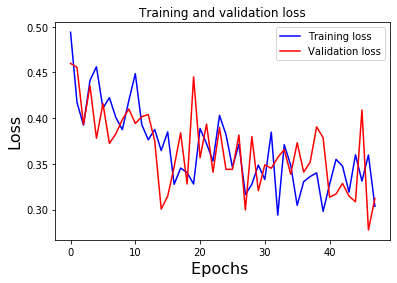

<Figure size 432x288 with 0 Axes>

Epoch: 49/50... Training loss: 0.3877 Validation loss: 0.3591


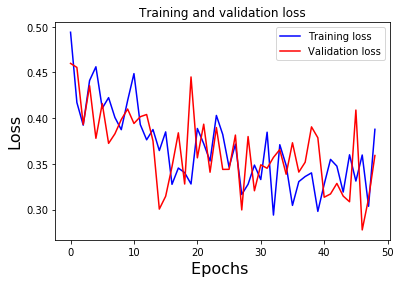

<Figure size 432x288 with 0 Axes>

Epoch: 50/50... Training loss: 0.3285 Validation loss: 0.3630


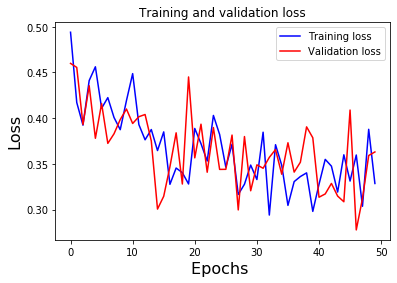

<Figure size 432x288 with 0 Axes>

In [6]:
for e in range(epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    for ibatch in range(total_batch):
        batch_train_x = mnist.train.next_batch(batch_size)
        batch_test_x = mnist.test.next_batch(batch_size)
        
        imgs_train = batch_train_x[0].reshape((-1, 28, 28, 1))
        x_train_noisy = Mode_mixing_batch(imgs_train,batch_size)
        #x_train_noisy = np.clip(x_train_noisy, 0., 1.)
        
        imgs_test = batch_test_x[0].reshape((-1, 28, 28, 1))
        x_test_noisy =  Mode_mixing_batch(imgs_test,batch_size)
        #x_test_noisy = np.clip(x_test_noisy, 0., 1.)
        
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_:x_train_noisy ,targets_:imgs_train, learning_rate:lr})

        batch_cost_test = sess.run(cost, feed_dict={inputs_:x_test_noisy,targets_:imgs_test})
    if (e + 1) % display_step == 0:
        print("Epoch: {}/{}...".format(e + 1, epochs),
              "Training loss: {:.4f}".format(batch_cost),
              "Validation loss: {:.4f}".format(batch_cost_test))

    loss.append(batch_cost)
    valid_loss.append(batch_cost_test)
    plt.plot(range(e + 1), loss, 'b', label='Training loss')
    plt.plot(range(e + 1), valid_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()
    saver.save(sess, './encode_model/')



画出结果。

Original Images


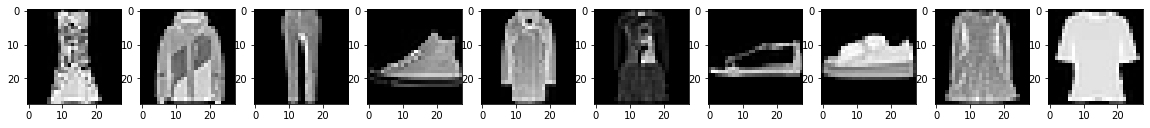

Noisy Images


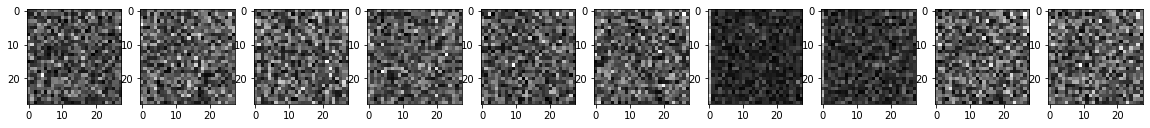

Reconstruction of Noisy Images


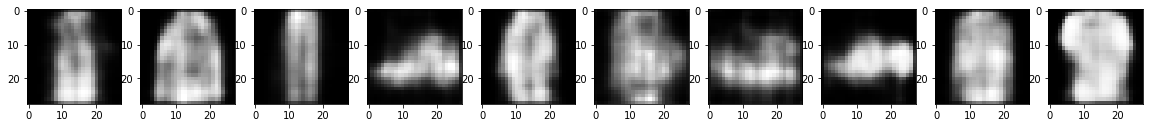

In [7]:
batch_x = mnist.test.next_batch(10)
imgs = batch_x[0].reshape((-1, 28, 28, 1))
x_test_noisy = Mode_mixing_batch(imgs,10)
#x_test_noisy = np.clip(x_test_noisy, 0., 1.)
recon_img = sess.run([decoded], feed_dict={inputs_: x_test_noisy})[0]
plt.figure(figsize=(20, 4))
plt.title('Reconstructed Images')
print("Original Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(imgs[i, ..., 0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Noisy Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(recon_img[i, ..., 0], cmap='gray')
plt.show()
writer.close()
sess.close()

In [0]:
'''
from numpy.linalg import pinv,inv

iTM = pinv(TM)

outmodes = fft2(outimage).flatten()

inmodes = iTM @ outmodes
inmodes = inmodes.reshape((28,28))

inimage = ifft2(inmodes)
plt.imshow(abs(inimage),cmap = 'gray')

'''